# Text Summarization With TensorFlow

Artifacts of Google colab have been left in because this will not run on my machine. 

Using neural networks, abstractive summaries of news articles are (attempted) to be made. Encoder/Decoder architectures are implemented, and a custom attention layer is used. 

Data is taken from [here](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/GMFCTR), but any textual data set could be used if cleaned appropriately.

While several similar resources were consulterd, [this blog post](https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/) by [Aravind Pai](https://www.linkedin.com/in/aravind-pai-57a1bb180/) was most helpful and provided the custom attention layer. However, TensorFlow has a [seq2seq guide](https://www.tensorflow.org/addons/tutorials/networks_seq2seq_nmt) that is more or less this implementation for English to German translation.

In [105]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import pickle
from sklearn.model_selection import train_test_split as tts

from keras import backend as K 
from keras.models import Sequential, Model
from keras.layers import Dense, Input, LSTM, RepeatVector, TimeDistributed, Concatenate, Attention
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.models import load_model

import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model


from gensim.summarization import summarize
import spacy
import nltk
from nltk.corpus import stopwords   
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [107]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]
    # code i am adding to enable model saving and loading
    # https://www.tensorflow.org/guide/keras/save_and_serialize#custom_objects
    # https://stackoverflow.com/questions/62280161/saving-keras-models-with-custom-layers
    def get_config(self):
      config = super(AttentionLayer, self).get_config()
      return config

In [108]:
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

In [109]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [110]:
data = pd.read_csv('/content/drive/MyDrive/DSIO6/Wiki Summary Bot/data/NewsArticles.csv', encoding='latin')
# data = pd.read_csv('/content/drive/MyDrive/DSIO6/Wiki Summary Bot/data/NewsArticles.csv', encoding= 'unicode_escape')
data.head()

,article_id,publish_date,article_source_link,title,subtitle,text,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65,Unnamed: 66,Unnamed: 67,Unnamed: 68,Unnamed: 69,Unnamed: 70,Unnamed: 71,Unnamed: 72,Unnamed: 73,Unnamed: 74,Unnamed: 75,Unnamed: 76,Unnamed: 77,Unnamed: 78,Unnamed: 79,Unnamed: 80,Unnamed: 81,Unnamed: 82,Unnamed: 83,Unnamed: 84,Unnamed: 85,Unnamed: 86,Unnamed: 87,Unnamed: 88,Unnamed: 89,Unnamed: 90,Unnamed: 91,Unnamed: 92,Unnamed: 93,Unnamed: 94,Unnamed: 95,Unnamed: 96,Unnamed: 97,Unnamed: 98,Unnamed: 99,Unnamed: 100,Unnamed: 101,Unnamed: 102,Unnamed: 103,Unnamed: 104,Unnamed: 105,Unnamed: 106,Unnamed: 107,Unnamed: 108,Unnamed: 109,Unnamed: 110,Unnamed: 111,Unnamed: 112,Unnamed: 113,Unnamed: 114,Unnamed: 115,Unnamed: 116,Unnamed: 117,Unnamed: 118,Unnamed: 119,Unnamed: 120,Unnamed: 121,Unnamed: 122,Unnamed: 123,Unnamed: 124,Unnamed: 125,Unnamed: 126,Unnamed: 127,Unnamed: 128,Unnamed: 129,Unnamed: 130,Unnamed: 131,Unnamed: 132,Unnamed: 133,Unnamed: 134,Unnamed: 135,Unnamed: 136,Unnamed: 137,Unnamed: 138,Unnamed: 139,Unnamed: 140,Unnamed: 141,Unnamed: 142,Unnamed: 143
0,1,2017/2/7,http://abcnews.go.com/Politics/pence-break-tie...,"Betsy DeVos Confirmed as Education Secretary, ...",NaN,Michigan billionaire education activist Betsy ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2017/2/7,http://abcnews.go.com/Politics/wireStory/melan...,Melania Trump Says White House Could Mean Mill...,NaN,First lady Melania Trump has said little about...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2017/2/7,http://abcnews.go.com/Politics/wireStory/trump...,"As Trump Fears Fraud, GOP Eliminates Election ...",NaN,A House committee voted on Tuesday to eliminat...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2017/2/7,http://abcnews.go.com/Politics/appeals-court-d...,Appeals Court t

### Preliminary Analysis and Cleaning

In [111]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3824 entries, 0 to 3823
Columns: 144 entries, article_id to Unnamed: 143
dtypes: float64(4), int64(1), object(139)
memory usage: 4.2+ MB


In [112]:
data['text'][0]

'Michigan billionaire education activist Betsy DeVos was confirmed today to serve as the secretary of education in President Trump\'s administration, after Vice President Mike Pence cast a tie-breaking vote in the Senate. The Senate voted on DeVos"?highly contentious nomination this afternoon, and the tally was split evenly, requiring Pence to use his authority as president of the upper chamber of Congress to break the impasse. This was the first time that a vice president has broken a tie to confirm a Cabinet nominee. Pence read the vote count 50-50 and then voted himself, rendering the tally 51-50. The day before the vote, Democrats staged a 24-hour marathon of speeches, with more than 30 lawmakers taking to the floor to urge at least one additional Republican to vote against DeVos and block her confirmation. "It is hard to imagine a worse choice,"?Sen. Elizabeth Warren, D-Mass., said before she read letters from constituents urging her to vote no. DeVos stirred up vehement oppositio

In [113]:
data['text'].str.len().describe()

count     3791.000000
mean      3311.367449
std       2483.617824
min          2.000000
25%       1589.000000
50%       2718.000000
75%       4402.000000
max      28397.000000
Name: text, dtype: float64

In [114]:
# one article has a length of 2?
data[data['text'].str.len() < 100]

,article_id,publish_date,article_source_link,title,subtitle,text,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65,Unnamed: 66,Unnamed: 67,Unnamed: 68,Unnamed: 69,Unnamed: 70,Unnamed: 71,Unnamed: 72,Unnamed: 73,Unnamed: 74,Unnamed: 75,Unnamed: 76,Unnamed: 77,Unnamed: 78,Unnamed: 79,Unnamed: 80,Unnamed: 81,Unnamed: 82,Unnamed: 83,Unnamed: 84,Unnamed: 85,Unnamed: 86,Unnamed: 87,Unnamed: 88,Unnamed: 89,Unnamed: 90,Unnamed: 91,Unnamed: 92,Unnamed: 93,Unnamed: 94,Unnamed: 95,Unnamed: 96,Unnamed: 97,Unnamed: 98,Unnamed: 99,Unnamed: 100,Unnamed: 101,Unnamed: 102,Unnamed: 103,Unnamed: 104,Unnamed: 105,Unnamed: 106,Unnamed: 107,Unnamed: 108,Unnamed: 109,Unnamed: 110,Unnamed: 111,Unnamed: 112,Unnamed: 113,Unnamed: 114,Unnamed: 115,Unnamed: 116,Unnamed: 117,Unnamed: 118,Unnamed: 119,Unnamed: 120,Unnamed: 121,Unnamed: 122,Unnamed: 123,Unnamed: 124,Unnamed: 125,Unnamed: 126,Unnamed: 127,Unnamed: 128,Unnamed: 129,Unnamed: 130,Unnamed: 131,Unnamed: 132,Unnamed: 133,Unnamed: 134,Unnamed: 135,Unnamed: 136,Unnamed: 137,Unnamed: 138,Unnamed: 139,Unnamed: 140,Unnamed: 141,Unnamed: 142,Unnamed: 143
75,76,2017/2/7,http://www.bbc.co.uk/news/world-us-canada-3889...,Barack Obama goes kitesurfing with Richard Bra...,NaN,Former US President Barack Obama has enjoyed a...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
279,280,2017/2/6,http://www.dw.com/en/bringing-back-ukraine-s-b...,Bringing back Ukraine's buffalo,The Carpathian buffalo was once a popular live...,- -,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
736,737,2017/2/9,http://www.bbc.co.uk/news/science-environment-...,Orphaned dik-dik raised by keepers,NaN,He's only 19cm (7.4 in) tall and has been name...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1006,1007,2017/2/13,http://www.huffingtonpost.com/SPOTTOON/spottoo...,NECROMANCER - Ep.5,NaN,Updated ever

In [115]:
data.columns

Index(['article_id', 'publish_date', 'article_source_link', 'title',
       'subtitle', 'text', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8',
       'Unnamed: 9',
       ...
       'Unnamed: 134', 'Unnamed: 135', 'Unnamed: 136', 'Unnamed: 137',
       'Unnamed: 138', 'Unnamed: 139', 'Unnamed: 140', 'Unnamed: 141',
       'Unnamed: 142', 'Unnamed: 143'],
      dtype='object', length=144)

Investigating the short entries, it appears some articles have been split across the many un-named columns. I'll join them all together.

In [116]:
# text_df is really a series rn
text_df = data.iloc[:,5:].fillna('')
text_df = text_df.iloc[:,:].astype(str)
text_df = text_df.iloc[:,:].apply(lambda x: " ".join(x), axis=1)
text_df = pd.DataFrame({'text': text_df})
text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3824 entries, 0 to 3823
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3824 non-null   object
dtypes: object(1)
memory usage: 30.0+ KB


With the articles all in one column, cleaning can continue,

In [117]:
text_df['text'].str.len().describe()

count     3824.000000
mean      3434.788441
std       2496.424231
min        138.000000
25%       1703.250000
50%       2837.500000
75%       4537.500000
max      28535.000000
Name: text, dtype: float64

In [118]:
len(data.iloc[:,5:].columns)

139

In [119]:
text_df.index

RangeIndex(start=0, stop=3824, step=1)

In [120]:
text_df[text_df['text'].str.len()==138]['text'][21]

'                                                                                                                                          '

it appears the entries of 138 length are formed from columns that are completely empty. Stripping whitespace should prove this.

In [121]:
text_df['stripped_text'] = text_df['text'].str.strip()
text_df['stripped_text'] = text_df['stripped_text'].str.strip()
text_df['stripped_text'].str.len().describe()

count     3824.000000
mean      3296.898274
std       2496.663821
min          0.000000
25%       1565.250000
50%       2699.500000
75%       4399.250000
max      28396.000000
Name: stripped_text, dtype: float64

Yepp, some entries are empty. Drop them.

In [122]:
is_blank_filter = text_df['stripped_text'].str.len() == 0
text_df = text_df[~is_blank_filter]
# is_blank_filter.sum() -> 33 entries dropped

text_df['stripped_text'].str.len().describe()

count     3791.000000
mean      3325.597204
std       2488.400761
min          2.000000
25%       1602.500000
50%       2722.000000
75%       4417.000000
max      28396.000000
Name: stripped_text, dtype: float64

New minimum length of 2 characters. Let's check those out.

In [123]:
text_df[text_df['stripped_text'].str.len() == 2]

,text,stripped_text
1151,-1 ...,-1
1154,-1 ...,-1
1930,-1 ...,-1
3695,-1 ...,-1


These have values of '-1', which is probably the original encoding for null values. Drop them as above.

In [124]:
is_neg_one_filter = text_df['stripped_text'].str.len() == 2
text_df = text_df[~is_neg_one_filter]
# is_neg_one_filter.sum() -> 4 entries dropped

text_df['stripped_text'].str.len().describe()

count     3787.000000
mean      3329.107737
std       2487.367581
min          3.000000
25%       1607.000000
50%       2726.000000
75%       4418.000000
max      28396.000000
Name: stripped_text, dtype: float64

Ok, now the min length is 3. Investigate

In [125]:
text_df[text_df['stripped_text'].str.len() == 3]

,text,stripped_text
279,- - ...,- -


Another placeholder value. Nix it.

In [126]:
is_dashes_filter = text_df['stripped_text'].str.len() == 3
text_df = text_df[~is_dashes_filter]
# is_dashes_filter.sum() -> just 1 dropped

text_df['stripped_text'].str.len().describe()

count     3786.000000
mean      3329.986265
std       2487.108456
min         13.000000
25%       1607.250000
50%       2726.500000
75%       4418.000000
max      28396.000000
Name: stripped_text, dtype: float64

New min length is 13 characters. We're getting closer to articles of menaingful length, continue investigating.

In [127]:
text_df[text_df['stripped_text'].str.len() == 13]

# data.loc[2949]
# data.loc[1978]
# commented out bc all ~140 columns are displayed.
# this is to confirm there isn't full article text hidden in the title,
# subtitle, or unnamed cols

,text,stripped_text
1978,View Comments ...,View Comments
2949,View Comments ...,View Comments


Just 2 of these, and they're just 'View Comments'. Useless so lose them.

In [128]:
is_view_comments_filter = text_df['stripped_text'].str.len() == 13
text_df = text_df[~is_view_comments_filter]

text_df['stripped_text'].str.len().describe()

count     3784.000000
mean      3331.739429
std       2486.595847
min         27.000000
25%       1608.750000
50%       2727.000000
75%       4418.250000
max      28396.000000
Name: stripped_text, dtype: float64

Min of 27, keep going

In [129]:
print(text_df[text_df['stripped_text'].str.len() == 27]['stripped_text'])


2476    Producer/Host: Anke Rasper-
Name: stripped_text, dtype: object


In [130]:
# long output
# data.loc[2476]

Down to just one value for these short entries, so there likely isn't a sytemic issue. Check value counts to see what is going.

In [131]:
text_df['stripped_text'].str.len().value_counts().sort_index()[:50]

27     1
54     1
55     1
81     1
88     1
89     1
100    1
101    1
116    1
117    1
118    1
136    1
160    1
166    1
172    2
173    1
186    1
188    1
206    1
211    1
214    1
215    1
226    1
235    1
242    3
245    1
246    1
250    2
255    2
263    1
264    1
267    1
268    1
270    1
272    1
273    1
276    1
278    1
284    1
285    1
287    1
288    1
298    1
300    1
301    1
305    1
306    1
318    1
320    1
323    1
Name: stripped_text, dtype: int64

In [132]:
print(text_df[text_df['stripped_text'].str.len() == 55]['stripped_text'])

736    He's only 19cm (7.4 in) tall and has been name...
Name: stripped_text, dtype: object


Some of these seem to be what I would consider 1-line articles. They have titles, but very short bodies. I'm going to grab the indexes and see if there articles have been broken up into different rows.

In [133]:
text_df[text_df['stripped_text'].str.len() < 500].index

Int64Index([  67,   75,   82,   83,   84,   86,   87,   88,   89,   90,
            ...
            3442, 3446, 3449, 3452, 3545, 3550, 3709, 3726, 3758, 3810],
           dtype='int64', length=128)

In [203]:
#long output commented out for readability
# text_df[text_df['stripped_text'].str.len() < 500]

While there are some sequential occurences, there doesn't appear to be any relation to them. So far, filtering has been done at the character level. I believe I'm ready to move onto some tokenizing to investigate and filter at the sentence level.

In [135]:
text_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3784 entries, 0 to 3823
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           3784 non-null   object
 1   stripped_text  3784 non-null   object
dtypes: object(2)
memory usage: 88.7+ KB


Actually cleaning the text. A few different functions were written to clean. The first breaks up each article into a list of wwords, then checks the word itself and the characters of each word for common errant values. This is easily expandable, but resulted in some words being joined together. For now, a second function is used that makes use of splits and regex subs.

In [136]:
def clean_text(text):
  to_drop = ["", '...']
  drop_chars = ['\"', "?"]
  cleaned_text = []
  text_list = text.split(" ")
  
  for word in text_list:
    if word is not to_drop:
      # cleaned_text.append(word)

      characters = []
      length = len(word) - 1
      
      for i, char in enumerate(word):
        if i == length and char == "?":
          characters.append(char)
        elif char not in drop_chars:
          characters.append(char)
      
      word = "".join(characters)
      cleaned_text.append(word)

  return " ".join(cleaned_text)


In [137]:
def clean_text2(text):
  text = " ".join(text.split("\"?"))
  text = " ".join(text.split(" -- "))
  text = " ".join(text.split("..."))
  text = re.sub('\s\s+', ' ', text)
  text = re.sub('--+', "", text)

  text = text.lower()

  return text
  
text_df['cleaned_text'] = text_df['stripped_text'].apply(clean_text2)
text_df['cleaned_text'] = text_df['cleaned_text'].apply(lambda x: ''.join(["" if ord(i) > 128 else i for i in x]))

In [138]:
text_df['cleaned_text'][0]

'michigan billionaire education activist betsy devos was confirmed today to serve as the secretary of education in president trump\'s administration, after vice president mike pence cast a tie-breaking vote in the senate. the senate voted on devos highly contentious nomination this afternoon, and the tally was split evenly, requiring pence to use his authority as president of the upper chamber of congress to break the impasse. this was the first time that a vice president has broken a tie to confirm a cabinet nominee. pence read the vote count 50-50 and then voted himself, rendering the tally 51-50. the day before the vote, democrats staged a 24-hour marathon of speeches, with more than 30 lawmakers taking to the floor to urge at least one additional republican to vote against devos and block her confirmation. "it is hard to imagine a worse choice, sen. elizabeth warren, d-mass., said before she read letters from constituents urging her to vote no. devos stirred up vehement opposition 

In [139]:
# stop_words = set(stopwords.words('english')) 
# def remove_stops(text_doc):
#   text_list = list(text_doc)
#   no_stops =[]
#   no_stops = [w for w in text_doc if not w in stop_words] 
#   return no_stops
#       #(" ".join(no_stops)).strip()

# remove_stops(text_df['docs'][0])


In [140]:
# [w for w in text_df['docs'][0] if not w in stop_words]

While stop words are usually removed, I am experimenting with generating grmatically correct sentences. I expect performance to be improved by removing stop words, but I want to see if they will be appropriately handled by the attention mechanism in the modeling. 

(As a post-modleing note, the non-attention model had a stronger tendency to repeat more common words for longer stretches. The attention mechanism seemed to treat stopwords as less relevant.)

### Tokenization

In [141]:
nlp = spacy.load('en')
text_df['docs'] = text_df['cleaned_text'].apply(lambda x: nlp(x))

In [142]:
text_df['sent_lists'] = text_df['docs'].apply(lambda x: list(x.sents))

In [143]:
# sentence counts of each article
text_df['sent_counts'] = text_df['sent_lists'].apply(lambda x: len(x))

In [144]:
text_df.tail()

,text,stripped_text,cleaned_text,docs,sent_lists,sent_counts
3819,The tribunal set up to investigate an alleged ...,The tribunal set up to investigate an alleged ...,the tribunal set up to investigate an alleged ...,"(the, tribunal, set, up, to, investigate, an, ...","[(the, tribunal, set, up, to, investigate, an,...",42
3820,Plans to tilt the wreckage of Coast Guard Resc...,Plans to tilt the wreckage of Coast Guard Resc...,plans to tilt the wreckage of coast guard resc...,"(plans, to, tilt, the, wreckage, of, coast, gu...","[(plans, to, tilt, the, wreckage, of, coast, g...",17
3821,Children in Northern Ireland are eating three ...,Children in Northern Ireland are eating three ...,children in northern ireland are eating three ...,"(children, in, northern, ireland, are, eating,...","[(children, in, northern, ireland, are, eating...",13
3822,Hundreds of people with disabilities and their...,Hundreds of people with disabilities and their...,hundreds of people with disabilities and their...,"(hundreds, of, people, with, disabilities, and...","[(hundreds, of, people, with, disabilities, an...",10
3823,All ten victims of a fire at a halting site in...,All ten victims of a fire at a halting site in...,all ten victims of a fire at a halting site in...,"(all, ten, victims, of, a, fire, at, a, haltin...","[(all, ten, victims, of, a, fire, at, a, halti...",20


In [145]:
text_df['cleaned_text'][0]

'michigan billionaire education activist betsy devos was confirmed today to serve as the secretary of education in president trump\'s administration, after vice president mike pence cast a tie-breaking vote in the senate. the senate voted on devos highly contentious nomination this afternoon, and the tally was split evenly, requiring pence to use his authority as president of the upper chamber of congress to break the impasse. this was the first time that a vice president has broken a tie to confirm a cabinet nominee. pence read the vote count 50-50 and then voted himself, rendering the tally 51-50. the day before the vote, democrats staged a 24-hour marathon of speeches, with more than 30 lawmakers taking to the floor to urge at least one additional republican to vote against devos and block her confirmation. "it is hard to imagine a worse choice, sen. elizabeth warren, d-mass., said before she read letters from constituents urging her to vote no. devos stirred up vehement opposition 

In [146]:
text_df['sent_counts']

0       16
1       37
2       27
3       22
4       27
        ..
3819    42
3820    17
3821    13
3822    10
3823    20
Name: sent_counts, Length: 3784, dtype: int64

### Gensim Summarization
This data does not have summaries. Gensim's summarization function uses the TextRank algorithm to identify the most important sentences. With these as training targets, the models will hopefully learn some grammar, and which parts of the source article is most important. Using a ratio summary means longer articles will have longer summaries.

In [147]:
text_df['cleaned_text'][1000]

'more than 180,000 people in northern california were ordered to evacuate-late on sunday due to erosion of the emergency spillway in the nation\'s tallest dam. several sikh temples in the area opened their doors to people in need of places to spend the night. earlier in the evening, california\'s department of water resources said the oroville dam\'s emergency spillway, which prevents water from rushing over the top of the dam when levels are high, was in danger of failing and sending an "uncontrolled release of flood waters from lake oroville. .@ca_dwr update on #orovillespillway pic.twitter.com/xzgp6xxyr6 thousands of residents from counties including yuba, butte and sutter were told to leave their homes immediately. sacramento mayor darrell steinberg tweeted that individuals evacuating the yuba county area could seek shelter in at least seven local sikh houses of worship in the area. sacramento is about an hour and a half south of oroville dam. sikh temples in sacramento region are 

In [148]:
summarize(text_df['cleaned_text'][500], ratio=0.1)

"no light at the end of the tunnel for a transport system that once was the undisputed world leader if you want to travel from kunming to shanghai, a mere 2,252 kilometers, it will take you 11 hours and 15 minutes- and you can bet your fancy high-speed train will be right on time.\ntraveling on china's new high-speed, state-of-the-art trains costs you an average of 100 yuan an hour, travelling at around 350 km/h."

In [149]:
text_df['sent_counts'].describe()

count    3784.000000
mean       27.835624
std        22.448860
min         1.000000
25%        13.000000
50%        22.000000
75%        36.000000
max       320.000000
Name: sent_counts, dtype: float64

In [150]:
# gensim summarizer requires more than 1 sentence
sum(text_df['sent_counts'] < 2) # 21 entries 

short_sent_filter = text_df['sent_counts'] < 13 

text_df = text_df[~short_sent_filter]

In [151]:
text_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2910 entries, 0 to 3823
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           2910 non-null   object
 1   stripped_text  2910 non-null   object
 2   cleaned_text   2910 non-null   object
 3   docs           2910 non-null   object
 4   sent_lists     2910 non-null   object
 5   sent_counts    2910 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 159.1+ KB


In [153]:
text_df['gensim_summaries'] = text_df['cleaned_text'].apply(lambda x: summarize(x, ratio=0.1))

In [154]:
text_df['gensim_summaries'].loc[3823]

'all ten victims of a fire at a halting site in carrickmines in dublin died of carbon monoxide poisoning, an inquest heard.'

In [155]:
def clean_summary(text):
  text = " ".join(text.split('\n'))

  return text

In [156]:
clean_summary(text_df['gensim_summaries'][555])

"from january to october, chinese companies had a cumulative direct investment of $145.96 billion (137 billion euros; 115.3 billion) overseas, with year-on-year growth of 53.3 percent, according to the latest report provided by china's ministry of commerce. from january to september, chinese enterprises spent $64.44 billion on mergers and acquisitions, $10 billion more than the total amount for last year, according to data provided by the ministry of commerce."

In [157]:
text_df['summary_docs'] = text_df['gensim_summaries'].apply(lambda x: nlp(x))

In [158]:
# list(text_df.loc[0,'docs'])

In [159]:
# adding start and end tokens for the modeling phase
text_df['start_gensim_summaries_stop'] = text_df['gensim_summaries'].apply(lambda x : '_START_ '+ x + ' _END_')
text_df['gensim_summaries'][0]

"michigan billionaire education activist betsy devos was confirmed today to serve as the secretary of education in president trump's administration, after vice president mike pence cast a tie-breaking vote in the senate."

# NLP EDA



Analyze length of articles by raw characters

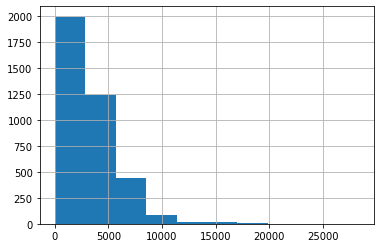

In [160]:
data['text'].str.len().hist()

Distribution of dates

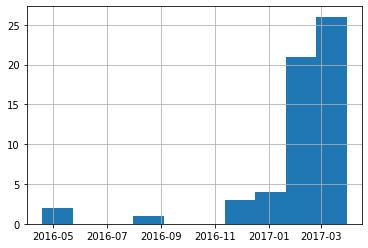

In [161]:
data['publish_date'] = pd.to_datetime(data['publish_date'])
data['publish_date'] = data['publish_date'].dt.date
date_counts = pd.DataFrame({'Date' : data['publish_date'].value_counts().index, 'Count': data['publish_date'].value_counts().values})
date_counts = date_counts.sort_values(by='Date')

date_counts['Date'].hist()

Distribution of sentence counts. Will take between 25%tile and 75%tile in length. 

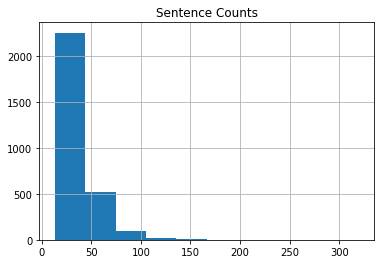

count    2910.000000
mean       33.766323
std        22.374904
min        13.000000
25%        19.000000
50%        27.000000
75%        41.000000
max       320.000000
Name: sent_counts, dtype: float64

In [167]:
text_df['sent_counts'].hist()
plt.title("Sentence Counts")
plt.show()
text_df['sent_counts'].describe()

Vocabulary by Article

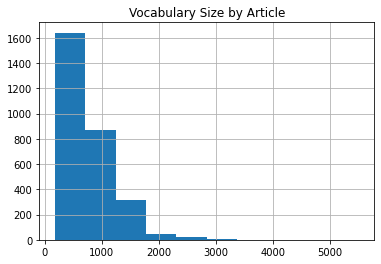

count    2910.000000
mean      768.753952
std       464.794809
min       172.000000
25%       446.250000
50%       640.000000
75%       963.000000
max      5512.000000
Name: docs, dtype: float64

In [172]:
text_df['docs'].apply(lambda x: len(set(x))).hist()
plt.title('Vocabulary Size by Article')
plt.show()
text_df['docs'].apply(lambda x: len(set(x))).describe()

Select article 75%tile and lower in length by sentence

In [173]:
# select shorter sentences here so exploration can be done above
long_sent_filter = text_df['sent_counts'] > 41

text_df = text_df[~long_sent_filter]

Re-examine length and vocabulary with articles filtered by length

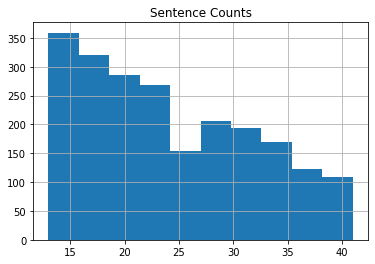

count    2189.000000
mean       24.050251
std         7.886607
min        13.000000
25%        17.000000
50%        23.000000
75%        30.000000
max        41.000000
Name: sent_counts, dtype: float64

In [202]:
text_df['sent_counts'].hist()
plt.title("Sentence Counts")
plt.show()
text_df['sent_counts'].describe()

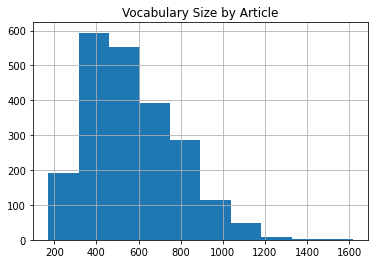

count    2189.000000
mean      570.197350
std       209.275442
min       172.000000
25%       412.000000
50%       536.000000
75%       711.000000
max      1616.000000
Name: docs, dtype: float64

In [174]:
text_df['docs'].apply(lambda x: len(set(x))).hist()
plt.title('Vocabulary Size by Article')
plt.show()
text_df['docs'].apply(lambda x: len(set(x))).describe()

Filtering by length normalizes these distributions nicely!

Average length of sentence per article, by word

In [196]:
def avg_sent_length(sent_list):
  lengths = []
  for sent in sent_list:
    lengths.append(len(sent))
  return np.mean(lengths)
  

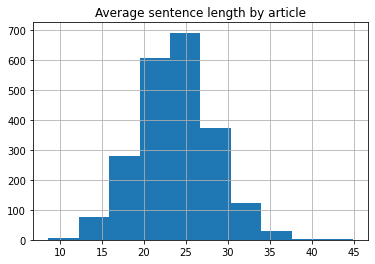

count    2189.000000
mean       23.835906
std         4.500159
min         8.621622
25%        20.947368
50%        23.781250
75%        26.636364
max        44.888889
Name: sent_lists, dtype: float64

In [200]:
text_df['sent_lists'].apply(lambda x: avg_sent_length(x)).hist()
plt.title('Average sentence length by article')
plt.show() # this kinda just demos the central limit theorem
text_df['sent_lists'].apply(lambda x: avg_sent_length(x)).describe()

Unique words in articles and in summaries

In [176]:
# join all articles together, split, and make a set to count unique words
# keras's one hot will remove puntuation, so this should be enough space
all_articles = text_df['cleaned_text'].str.cat(sep=" ")
num_words_corpus = len(set(all_articles.split(" ")))
num_words_corpus

78680

In [177]:
all_summaries = text_df['gensim_summaries'].str.cat(sep=" ")
num_words_sums = len(set(all_summaries.split(" ")))
num_words_sums

22663

### TF Tokenization
Tensorflow's Tokenization function is nice for several reasons. It provides methods to convert sequences back to text, and removes many common non-text characters. 

In [63]:
# Split data into training and test
X, X_test, y, y_test = tts(text_df['cleaned_text'], text_df['start_gensim_summaries_stop'], test_size=0.2, random_state=42, shuffle=True)


In [64]:
# split the training data into training and validation
X_train, X_val, y_train, y_val = tts(X, y, test_size=0.1, random_state=42, shuffle=True)

In [65]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))
print(len(X_val))
print(len(y_val))

1575
1575
438
438
176
176


In [66]:
# using tf one hot to get length of article bc it eliminates punctuation and spaces
vocab_size = num_words_corpus
text_df['encoded_docs'] = text_df['cleaned_text'].apply(lambda x: one_hot(x, vocab_size))

#text_df['encoded_docs']

text_df['encoded_docs_length'] = text_df['encoded_docs'].apply(lambda x: len(x))
max_length_article = text_df['encoded_docs_length'].max()
max_length_article

vocab_size = num_words_sums
text_df['encoded_sums'] = text_df['gensim_summaries'].apply(lambda x: one_hot(x, vocab_size))

text_df['encoded_sums_length'] = text_df['encoded_sums'].apply(lambda x: len(x))
max_length_summary = text_df['encoded_sums_length'].max()
max_length_summary

308

In [67]:
# initialize training tokenizer for inputs 
X_tokenizer = Tokenizer()
X_tokenizer.fit_on_texts(list(X_train)) # fit to whole corpus? am i losing vocab fitting only on trianing?

# convert to sequences
X_train_seqs = X_tokenizer.texts_to_sequences(X_train)
X_val_seqs = X_tokenizer.texts_to_sequences(X_val)
X_test_seqs = X_tokenizer.texts_to_sequences(X_test)

# pad sequences
X_train_seq_pad = pad_sequences(X_train_seqs, maxlen=max_length_article, padding='post')
X_val_seq_pad = pad_sequences(X_val_seqs, maxlen=max_length_article, padding='post')
X_test_seq_pad = pad_sequences(X_test_seqs, maxlen=max_length_article, padding='post')

# store training vocab size
X_voc_size = len(X_tokenizer.word_index) + 1

In [68]:
max_length_article

1419

In [69]:
# just checking that the tokenizer and onehot give the same result for max length
print(max(len(elem) for elem in X_train_seqs))
print(max(len(elem) for elem in X_test_seqs))
print(max(len(elem) for elem in X_val_seqs))
print(max_length_article)

1419
1126
1194
1419


In [70]:
# input training tokenizer for targets
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train)) # fit to whole corpus? am i losing vocab fitting only on trianing?

# convert to sequences
y_train_seqs = y_tokenizer.texts_to_sequences(y_train)
y_val_seqs = y_tokenizer.texts_to_sequences(y_val)
y_test_seqs = y_tokenizer.texts_to_sequences(y_test)

# pad sequences
y_train_seq_pad = pad_sequences(y_train_seqs, maxlen=max_length_summary, padding='post')
y_val_seq_pad = pad_sequences(y_val_seqs, maxlen=max_length_summary, padding='post')
y_test_seq_pad = pad_sequences(y_test_seqs, maxlen=max_length_summary, padding='post')

# store training vocab size
y_voc_size = len(y_tokenizer.word_index) + 1

In [71]:
print(max(len(elem) for elem in y_train_seqs))
print(max(len(elem) for elem in y_test_seqs))
print(max(len(elem) for elem in y_val_seqs))
print(max_length_summary)

310
208
190
308


### Model Building
* Model 1: Simple Encoder/Decoder
  * Enocder:
    * Reads in source one word at a time
    * Learns context of sequence
    * Final state initializes decoder
  * Decoder
    * Encoder, but for target minus 1
    * Trained to predict next step in target



In [73]:
# converting encoded data to shorter names
x_tr = X_train_seq_pad
y_tr = y_train_seq_pad
x_val = X_val_seq_pad
y_val = y_val_seq_pad

Enocder-Decoder Training Model

In [75]:
print("Size of vocabulary from the w2v model = {}".format(vocab_size))


x_voc = X_voc_size
y_voc = y_voc_size

src_text_length = max_length_article
sum_text_length = max_length_summary

K.clear_session()

latent_dim = 150
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(src_text_length,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

####################################################################################################################
# The model was trained and then saved. The loss history was also saved. Both are loaded back in for time's sake,
# and the code to train and save is included below

# Define the model 
# model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

# history=model.fit([x_tr, y_tr[:,:-1]], 
#                     y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:], 
#                     epochs=50, 
#                     batch_size=128,
#                     validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]),
#                     callbacks=[es]
#                     )


# model.save(filepath='/content/drive/MyDrive/DSIO6/Wiki Summary Bot/model1.h5')

# with open('/content/drive/MyDrive/DSIO6/Wiki Summary Bot/training_history.pickle', 'wb') as f:
#   pickle.dump(history.history, f)
######################################################################################################################


# loss history from training
train_history_dict = pickle.load(open('/content/drive/MyDrive/DSIO6/Wiki Summary Bot/training_history.pickle', 'rb'))

# the loaded model is saved and loaded already compiled
model = load_model('/content/drive/MyDrive/DSIO6/Wiki Summary Bot/model1.h5')
model.summary()

Size of vocabulary from the w2v model = 36487
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1419)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1419, 100)    3326800     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 1419, 150),  150600      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
_________________________________________

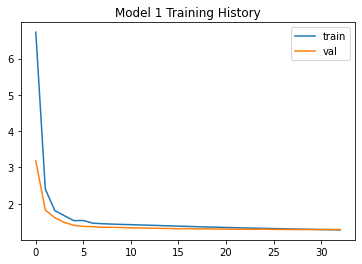

In [210]:
#train_history_dict = pickle.load(open('/content/drive/MyDrive/DSIO6/Wiki Summary Bot/training_history.pickle', 'rb'))
plt.plot(train_history_dict['loss'], label='train')
plt.plot(train_history_dict['val_loss'], label='val')
plt.legend()
plt.title('Model 1 Training History')
plt.show()

Really doesn't learn much past 5-10 epochs

### Enocder-Decoder Inference
Since we cannot use the target minus 1 like was done for training, some python will need to be used to implement functionalitytensorflow doesn't have. The source will be passed into the encoder, and the outputs and hidden states are then passed into the decoder. The decoder should then output a token as aprediction. The dictionaries made form the tf Tokenizer function allow the model output to be converted back into text. With some raw python, the token is checked to be a stop token. If it is not and the summary is not the maximum length, the word is appended. The internal states of the decoder and the output token are used as the next input of the decoder, allowing for a non-vanilla recursive tensorflow loop!

In [82]:
# Creating dictionaries from the tf tokenization function
# these allow us to easily get the words from the encodings
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = X_tokenizer.index_word
target_word_index = y_tokenizer.word_index
source_word_index = X_tokenizer.word_index

In [84]:
# this cell defines nessecary components, but IS NOT the flow of the process
# that is below
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# store the previous states
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_length_article, latent_dim))

# get decoder embeddings
dec_emb2 = dec_emb_layer(decoder_inputs)

# to predict the next word, set the the initial states from the previous step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

decoder_outputs = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2]
)

In [85]:
# implement inference process
def decode_sequence(input_seq):
  e_out, e_h, e_c = encoder_model(input_seq)

  # Generate empty target of length 1
  target_seq = np.zeros((1,1))

  # choose the "start" word as first word
  # be wary: 'start' and 'end' can appear inside of the summary as well.
  target_seq[0, 0] = target_word_index['start']

  stop_condition = False
  decoded_sentence = ''
  while not stop_condition:
    # print(len(decoded_sentence.split())) # was testing if non padding was gen'd
    output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

    # Sample a token
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    if sampled_token_index == 0:
      stop_condition = True
      break

    
    sampled_token = reverse_target_word_index[sampled_token_index]

    if (sampled_token != 'end'):
      decoded_sentence += " " + sampled_token

      # Exit condition: either reach max sum length, or find termination word
        # source code has an indented if statement:
        # if ():
      if (sampled_token =='end' or len(decoded_sentence.split()) >= (max_length_summary-1)):
        stop_condition = True
  
    # update target sequence (of length 1)
    target_seq = np.zeros((1,1))
    target_seq[0,0] = sampled_token_index

    # update internal states
    e_h, e_c = h, c 

  return decoded_sentence

In [86]:
# functions to convert from tokens to words. Not the best since the tokenizer
# was fit on just the training data, so converting the test and val seqs to 
# words reults in nonsense
def seq2summary(input_seq):
  newString = ""
  for i in input_seq:
    if((i != 0 and i != target_word_index['start']) and i != target_word_index['end']):
      newString = newString + reverse_target_word_index[i] + " "
  return newString

def seq2text(input_seq):
  newString = ""
  for i in input_seq:
    if(i != 0):
      newString = newString + reverse_source_word_index[i] + " "
    
  return newString

In [87]:
# pseudo sampling the test data to geneate sequences. Printing every prediction 
# would be unnecessary, but visual inspection is the only metric for text data 
for i in np.arange(0, 436,20):
  print('Article ', X_test.iloc[i])
  print("Original Summary: ", y_test.iloc[i])
  print("Generated Summary: ", decode_sequence(X_test_seq_pad[i].reshape(1,max_length_article)))
  print('-'*500)

Article  east africa should continuously cooperate with developmental financial institutes, known as dfis, to deal with the peak period of debt repayment. countries in the region are dealing with a growing debt burden and will gradually reach the peak period for repayment, due to the major commitment to infrastructure financed by the dfis. one solution is for countries to cooperate with dfis continuously to deal with the repayment issue and convert the burden into an opportunity for growth. benefiting from infusions of external capital, east african countries have seen unprecedented levels of stable economic growth over the last decade. however, as a consequence, the peak period for debt repayment is also arriving. for example, kenya's treasury will have to deploy approximately 40 percent of its tax revenues just to service loans next year. should we view the side-effects of progress in loans as a sign to cut down engagement with dfis? the answer is definitely no. in fact, the current 

### Encoder-Decoder with Attention
This model aims to solve what the first is bad at: handling long inputs. The encoder/decoder really only makes use of the end of the source article, and the preceding target word. The attention layer (ideally) emphasizes parts of the source most related to the target. This is a custom layer I found with these architectures. However to save and load the model, I had to add a config method to the Attention Layer object. One of my biggest take aways from this project is how flexible tensorflow can be.

In [100]:
print("Size of vocabulary from the w2v model = {}".format(vocab_size))


x_voc = X_voc_size
y_voc = y_voc_size

src_text_length = max_length_article
sum_text_length = max_length_summary

K.clear_session()

latent_dim = 150
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(src_text_length,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention Layer
attn_layer = AttentionLayer(name='attention_layer')
# attn_layer = BahdanauAttention(10)
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# concat attention and decoder
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
# model2 = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# model2.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

# history2=model2.fit([x_tr, y_tr[:,:-1]], 
#                   y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:], 
#                   epochs=15, 
#                   batch_size=25,
#                   validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]),
#                   callbacks=[es]
#                   )

# model2.save(filepath='/content/drive/MyDrive/DSIO6/Wiki Summary Bot/model2.h5')
# with open('/content/drive/MyDrive/DSIO6/Wiki Summary Bot/training_history2.pickle', 'wb') as f:
#   pickle.dump(history2.history, f)

# the model was set to train for 15 more epochs, and stopped early aafter 7.
# the history was saved again
# with open('/content/drive/MyDrive/DSIO6/Wiki Summary Bot/training_history2_more_training.pickle', 'wb') as f:
#   pickle.dump(history2.history, f)


# loss history from training
train_history2_dict = pickle.load(open('/content/drive/MyDrive/DSIO6/Wiki Summary Bot/training_history2.pickle', 'rb'))
second_train_history2_dict = pickle.load(open('/content/drive/MyDrive/DSIO6/Wiki Summary Bot/training_history2_more_training.pickle', 'rb'))
model2 = load_model('/content/drive/MyDrive/DSIO6/Wiki Summary Bot/model2.h5', custom_objects={"AttentionLayer": AttentionLayer})

model2.summary()

Size of vocabulary from the w2v model = 36487
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1419)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1419, 100)    3326800     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 1419, 150),  150600      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
_________________________________________

In [89]:
# model2.save(filepath='/content/drive/MyDrive/DSIO6/Wiki Summary Bot/model2.h5')
# with open('/content/drive/MyDrive/DSIO6/Wiki Summary Bot/training_history2_more_training.pickle', 'wb') as f:
#   pickle.dump(history2.history, f)

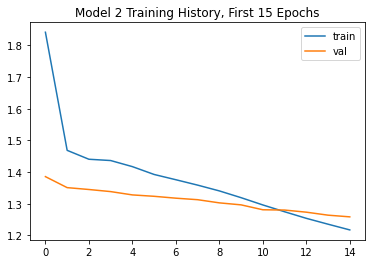

In [211]:
plt.plot(train_history2_dict['loss'], label='train')
plt.plot(train_history2_dict['val_loss'], label='val')
plt.legend()
plt.title('Model 2 Training History, First 15 Epochs')
plt.show()

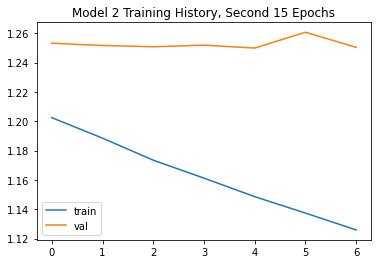

In [212]:
plt.plot(second_train_history2_dict['loss'], label='train')
plt.plot(second_train_history2_dict['val_loss'], label='val')
plt.legend()
plt.title('Model 2 Training History, Second 15 Epochs')
plt.show()

Inference with Attention

(Be sure model 2 is loaded in with its weights, the variable and layer names are the same as the previous model.)

In [101]:
# this cell defines nessecary components, but IS NOT the flow of the process
# that is below
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# store the previous states
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_length_article, latent_dim))

# get decoder embeddings
dec_emb2 = dec_emb_layer(decoder_inputs)

# to predict the next word, set the the initial states from the previous step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

decoder_outputs = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2]
)

In [102]:
# implement inference process
def decode_sequence(input_seq):
  e_out, e_h, e_c = encoder_model(input_seq)

  # Generate empty target of length 1
  target_seq = np.zeros((1,1))

  # choose the "start" word as first word
  # be wary: 'start' and 'end' can appear inside of the summary as well.
  target_seq[0, 0] = target_word_index['start']

  stop_condition = False
  decoded_sentence = ''
  while not stop_condition:
    # print(len(decoded_sentence.split())) # was testing if non padding was gen'd
    output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

    # Sample a token
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    if sampled_token_index == 0:
      stop_condition = True
      break

    
    sampled_token = reverse_target_word_index[sampled_token_index]

    if (sampled_token != 'end'):
      decoded_sentence += " " + sampled_token

      # Exit condition: either reach max sum length, or find termination word
        # source code has an indented if statement:
        # if ():
      if (sampled_token =='end' or len(decoded_sentence.split()) >= (max_length_summary-1)):
        stop_condition = True
  
    # update target sequence (of length 1)
    target_seq = np.zeros((1,1))
    target_seq[0,0] = sampled_token_index

    # update internal states
    e_h, e_c = h, c 

  return decoded_sentence

In [103]:
for i in np.arange(0, 436,20):
  print('Article ', X_test.iloc[i])
  print("Original Summary: ", y_test.iloc[i])
  print("Generated Summary: ", decode_sequence(X_test_seq_pad[i].reshape(1,max_length_article)))
  print('-'*500)

Article  east africa should continuously cooperate with developmental financial institutes, known as dfis, to deal with the peak period of debt repayment. countries in the region are dealing with a growing debt burden and will gradually reach the peak period for repayment, due to the major commitment to infrastructure financed by the dfis. one solution is for countries to cooperate with dfis continuously to deal with the repayment issue and convert the burden into an opportunity for growth. benefiting from infusions of external capital, east african countries have seen unprecedented levels of stable economic growth over the last decade. however, as a consequence, the peak period for debt repayment is also arriving. for example, kenya's treasury will have to deploy approximately 40 percent of its tax revenues just to service loans next year. should we view the side-effects of progress in loans as a sign to cut down engagement with dfis? the answer is definitely no. in fact, the current 

Generated Summary Exploration

In [207]:
summary1 = "rights her united united foreign foreign russia committee international mr international law mr international international to to mr to from him him wednesday him wednesday election been was was was were was was were was was were was was were was was were was was was were was was were was was was were was was were was was were was was was were was was were was was were was was was were was was were was was were was was was were was was were was was were was was was were was was were was was were was was was were was was were was was were was was was were was was were was was were was was was were was was were was was were was was was were was was were was was were was was was were was was were was was were was was was were was was were was was were was was was were was was were was was were was was was were was was were was was were was was was were was was were was was were was was was were was was were was was were was was was were was was were was was were was was was were was was were was was were was was was were was was were was was were was was was were was was were was was were was was was were was was were was was were was was was were was was were was was were was was was were was was were was was were was was was were was was were was was were was was was were was was were was was were was was was were was was were was was were was was was were was was were"
summary2 = "some some could could mr mr between between all party after after its after its after its president its this report we its this party from from international national national this to to had public had i at in executive administration administration our i united out out for out out for wednesday i out out out out for the wednesday year not i minister year military military trump trump million million after after after after or about about international before there there campaign state state last what made made said us us us country is country is country is country three country is report by percent country military years years who years who who public public this first first us former years this us us to to to had at at and wednesday in executive executive administration group administration our i campaign city into white million over million were were were were percent china police police on on on its group administration administration our start start white this white or about international there between between for between party all party after after its after its after its president its this report we this or international security wednesday international there there called be mr time when when people people people city federal i federal percent a house military was was new was new he would years who who executive executive executive executive over two two executive executive administration group administration executive administration administration our i into campaign has has president three state what by country by russia country by russia country by group officials as administration the our thursday the have was was administration administration our i administration our campaign city white three state what made said united more united more group that to to up about about executive executive administration administration our i united administration administration our"

summary1_list = summary1.split()
summary2_list = summary2.split()

In [208]:
print("Length of summary 1: ", len(summary1_list))
print("Length of summary 2: ", len(summary2_list))

print("Unique words summary 1: ", len(set(summary1_list)))
print("Unique words summary 2: ", len(set(summary2_list)))

Length of summary 1:  307
Length of summary 2:  307
Unique words summary 1:  17
Unique words summary 2:  89


### Results Discussion

  First, even getting these models to run was a victory in itself. Besides some reference material over simplifying the architectures, the models were incredibly demanding in terms of memory. The first model would throw Out of Memory errors with the whole training data until I upgraded to Colab Pro and switched to a TPU (tensor processing unit, specifically designed for a task like this). Once I established that worked, I implemented the attention layer and was met with outright notebook crashes. I eventually identified batch size as the culprit. My best guess is with the input articles being so long, the pre-allocated tensors were enormous. Reducing the batch size allowed me to fit the attention layer model, but it took several hours each for the two training sessions.

  With both models, the same summary is generated regardless of test input. This is.. strange, and undesirable. I have a few hypotheses on what could be causing this. First, the models may have learned the vocabularies, but not how to interpret the source text. Training weights may be what is determining these homogeneous predictions. There may also be a bug with loading the model and re-declaring  layers for inference. I have asusmed weights are applied to the layer instances, but the declarations in the inference could be ending up untrained. I thin kthis is less likely since I notice systemic differences in the predictions of the two models, however this could just be due to the presence of the attention layer evem if it is incorrectly trianed because of the model loading. Lasltly, predicitions are different every restart/run all. I am pretty sure this stochasticity is a combination of the tokenization function and the trainable embedding layer. Word tokens are different every run, and due to the small data set, the embedding has a high degree of variability in learning. Laslty, both summaries are of the full target length. This means a "stop" token is never generrated. This is another clue that the models are only learning the vocabularies. I will discuss how to overcome these obstacles below. 

  With the first model, it really only learns from the end of the source and immediately preceding target word. I notice more stop words, and longer sequences of more common words. 

The second model seems to have more nouns and shorter sequences of single-word repetition. This should be expected if the attention layer is working as expexted, as stopwords will have less relevance to the target.

  The above observations are somewhat of a stretch given al lthat could be improved. However, one consistent, logical, and obvious feature stands out: the ends of the summaries. In both models, the farther in the summary, the more removed from conext the predictions become. In the simple encoder/decoder model, it's heavy reliance on the preceding word is made apparent by it devolving into one or two common words such as " were was was were was was were was was was were was was were...". The attention model, however, devolves into a much more diverse set of less common words (albeit with some repition): "campaign city white three state what made said united more united more group that to to up about about executive executive administration administration our i united administration administration our". This demonstrates there is a difference in how the models have learned, and it aligns with the attention mechanism.

### Next Steps and Improvements
  Obviously, the current output is not useful. Changing the data is always the best place to start. Using more datato train would be a great first step. Training on an automatic, text-rank summaries is not ideal. Human made summaries would be better training targets, so the models can be exposed to true abstractive summarization. Having shorter source articles should increase performance as well, so more relevant information is retained by the recurrent layers and attention mechanism. 
  
 Counter to this, adding to the model more recurrent layers could aid in retaining more distant source states. Different or modified attention layers are also an avenue of exploration. The embedding layer is currently as vanilla as possible, and introduces a great deal of variability with training. There might also be some issue with the tokenizer changing encoding each restart, and the embedding being trained on a previous encoding. Tensorflow is unclear on the randomness of the Tokenize function, and testing by retraining would push days worth of hours. This also would not explain why the same predicition is being made for every test value. Pretrained embeddings, such as BERT, tokenize and preprocess autromatically. Not only should transferred embeddings represent word meanings better, they may also solve the tokenization problem. Lastly, some of my assumptions about tensorflow may be wrong. I have not been able to find a clear answer on the ramifications of loading the model, then instantiating new models from it for inference. Having more computing power would also make my life much, much easier.

### Uses and Applications

With what I have demonstrated, I believe it is possible to take long pieces of text, and abstract the main ideas out. There are two main audiences of this tool. First are editors for periodicals and news sources. News articles tend to have the most relevant information in the beginning, and many sites have existing summaries and headlines. This existing data could be used to train the model, and then summaries could be automatically generated. This would save editors and writers time. This application could also service news aggregation services or blog hosting services. Having a blurb be automatically generated for mobile notifications could drive usage for services where the provider is not necessarily directly working with the writers.

Secondly, this model could be implemented on online retail reviews. Many reviews already have the format of Long review with a few words summary, and of course a start rating. This is the perfect format to feed into this abstractive model. This could allow retailers to create standardized dropdowns for review summaries. Abstractive summaries should distill broad ideas and sentiments out of more specific text, and can be tied to other statistics such as usability, accuracy and satisfaction of what is being bought. 

In general, I believe with the right data this summarization model can automate common publication tasks, and provide insight on what users type. 